# Estimating vector $\pi$
Due to problems with conditioning, directly computing the vector $\pi$ that solves the optimization problem
$$
\pi_\star = \arg\max_{\pi \in \Delta_d} \;\; \min_{q \in \mathcal{P}_{d-1}} \sum_{i=1}^d \pi_i [1 - \lambda_i^* q(\lambda_i^*)]
$$
becomes infeasible with $d > 21$. Luckily, upon examining the solutions computed at for each $d \leq 21$ we see a pattern that allows us to estimate the vector $\pi$ for $d > 21$. We estimate this vector by fitting a set of models to the first ($\pi_1$) and last ($\pi_d$) elements of the vector $\pi$ and then fitting a separate model which handles all the elements in between. 

In [10]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
from scipy.optimize import minimize
from sklearn.metrics import mean_absolute_percentage_error

from experiment.regularized_quadratic import chebyshev_extrema, find_pi_cvx

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


We start by actually solving our problem until $d=21$ so that we have a set of solutions to fit our models to.

In [11]:
# Example parameters, results seem to extrapolate well enough
s = 0.1
p = 6
d = 21
L = 100
pis = []


rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)

# Iterate and solve for pi for each N
for d_ in range(2, d):

    # From bound
    r = (L / (3 * s * ((d_-1)/2)**2))**(1 / (p - 2))
    sr = s * r**(p-2)
    L_star = L + sr
    mu_star = 0 + sr
    cheb = chebyshev_extrema(L_star, mu_star, d_)

    # Solve for pi
    pi = find_pi_cvx(cheb, spn_replacement='QR', eps=1e-8, verbose=False)
    pis.append(pi)

We also generate figures so that we can have a look at the general shape of the vector $\pi$ for different values of $d$:

In [12]:
for pi in pis:
    d_ = len(pi)
    fig, ax = plt.subplots(figsize=(8, 5))
    ax.bar(range(1, d_+1), pi, color='blue')

    ax.text(0.925, 
            0.9, 
            f'$|\\pi| = {d_}$', 
            transform=ax.transAxes, 
            fontsize=40, 
            verticalalignment='top', 
            horizontalalignment='right',
            bbox = dict(boxstyle='round', facecolor='lightgray', alpha=0.5)
    )

    # Integer x-axis
    ax.set_xticks(range(1, d_+1))
    ax.set_xticklabels(['$\\pi_{' + str(i) + '}$' for i in range(1, d_+1)], fontsize=35)
    ax.locator_params(nbins=5, axis='y')
    plt.yticks(fontsize=35)

    plt.savefig(f'figures/pi_cvx/pi_cvx_{d_}.pdf')
    plt.savefig(f'figures/pi_cvx/pi_cvx_{d_}.png')
    plt.close()

The figures are saved in `figures/pi_cvx/` and can be examined from there. Here is an example when $|\pi| = 9$:

![Shape of pi with 9 elements](./figures/pi_cvx/pi_cvx_9.png){width=50%}

The general shape of the vector $\pi$ seems to be a roughly logarithmically decreasing function. But there is some irregularity in the first and last elements compared to the middle elements. Therefore we will use different models for the first and last elements and the middle elements. 

For the first and last elements we use the following model:
$$
\hat{\pi_i} = c_1^{-c_2(i - c_3)} + c_4.
$$
In the next few cells we use scipy to fit the coefficients $c_1, c_2, c_3$ and $c_4$ to the first and last elements of the vector $\pi$:

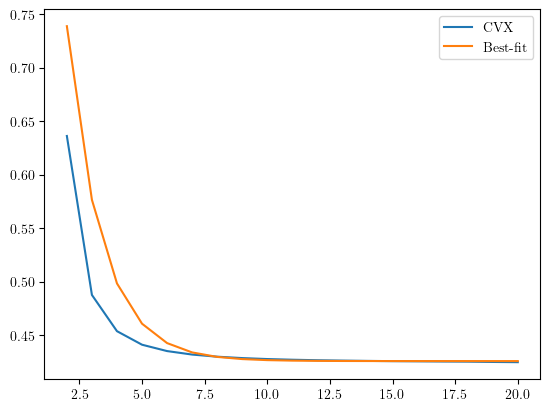

In [13]:
def first_coef(n, c1=2.0824014739014203, c2=0.9961791558193664, c3=0.41050294562291606, c4=0.42600453090655127):
    return c1**(-c2*(n-c3))+c4

first_coefs = [pi[0] for pi in pis]

def loss_f(c):
    preds = [first_coef(n, c[0], c[1], c[2], c[3]) for n in range(7, d)]  # Offset first few coefficients to avoid overfitting
    return mean_absolute_percentage_error(first_coefs[5:], preds)

res = minimize(loss_f, [1, 1, 0.41, 0])
c = res.x

plt.plot(range(2, d), first_coefs, label='CVX')
plt.plot(range(2, d), [first_coef(n, c[0], c[1], c[2], c[3]) for n in range(2, d)], label='Best-fit')
plt.legend()
plt.show()

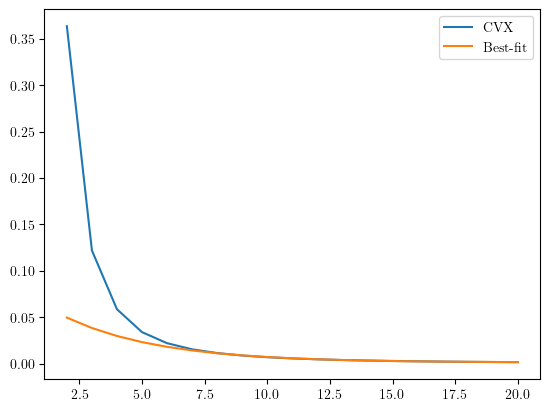

In [14]:
def last_coef(n, c1=2.0030004460202253, c2=0.3785972015639097, c3=-9.519199185333344, c4=0.001235242856667443):
    return c1**(-c2*(n-c3))+c4

last_coefs = [pi[-1] for pi in pis]

def loss_l(c):
    preds = [last_coef(n, c[0], c[1], c[2], c[3]) for n in range(7, d)]
    return mean_absolute_percentage_error(last_coefs[5:], preds)

res = minimize(loss_l, [1, 1, 0.41, 0])
c = res.x

plt.plot(range(2, d), last_coefs, label='CVX')
plt.plot(range(2, d), [last_coef(n, c[0], c[1], c[2]) for n in range(2, d)], label='Best-fit')
plt.legend()
plt.show()

We now turn our attention to the middle coefficients. We will use the following model:
$$
\hat{\pi_i} = \Big[c_2 (u - c_1)\Big]^{-c_3},
$$
where $u$ is the index of the middle element. We now perform the same fitting procedure for this model:

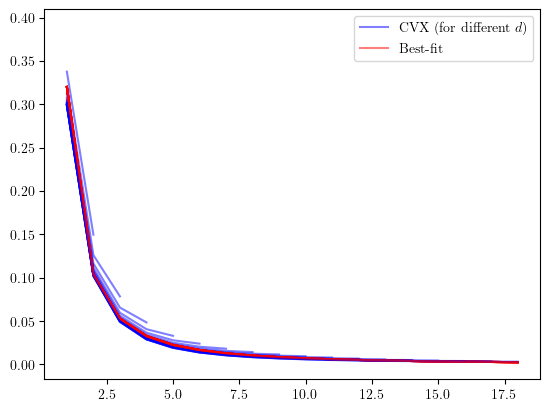

In [15]:
def middle_coefs(n, c1 = 0.060765593865534206, c2=1.8430375329834494, c3=1.6991040151256829):
    xs = c2 * (np.arange(1, n) + c1)
    return xs**(-c3)

def loss_m(c):
    cutoff = 1
    preds = [middle_coefs(n, c[0], c[1], c[2]) for n in range(cutoff+1, d)]
    errors = [mean_absolute_percentage_error(pi[1:-1], preds[i]) for i, pi in enumerate(pis[cutoff:])]
    return np.sum(errors)

res = minimize(loss_m, [0, 0, 0.41], tol=1e-15, bounds=[(None, 0.99), (1e-8, None), (None, None)])
c = res.x

# Plot middle coefficients in pis for all N
for i, pi in enumerate(pis):
    mc = pi[1:-1]
    d_ = len(pis)
    plt.plot(range(1, len(mc)+1), mc, color='blue', alpha=0.5, label='CVX (for different $d$)' if i == 0 else None)

    pred = middle_coefs(d_, c[0], c[1], c[2])
    plt.plot(range(1, len(pred)+1), pred, color='red', alpha=0.5, label='Best-fit' if i == 0 else None)

plt.legend()
plt.show()

We now put our models together and visually examine just how well our composite model predicts the vector $\pi$ for $d \leq 21$:

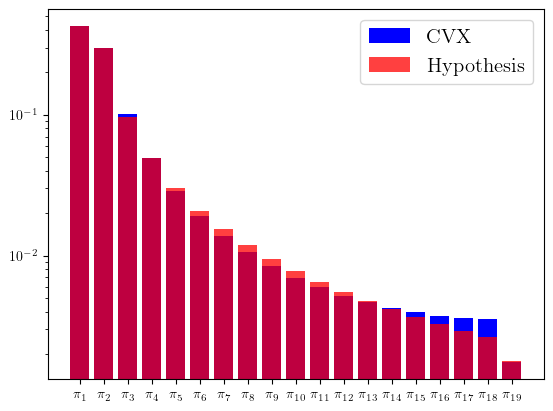

In [16]:
def pi_hypothesis(n):
    pi_0 = first_coef(n)
    pi_last = last_coef(n)
    pi_middle = middle_coefs(n-1)
    pi_middle = (1 - pi_0 - pi_last) * pi_middle / np.sum(pi_middle)
    pi = np.concatenate(([pi_0], pi_middle, [pi_last]))
    return pi

pis_hypothesis = [pi_hypothesis(n) for n in range(2, d)]
test_i = -2
pis_i = pis[test_i]
pish_i = pis_hypothesis[test_i]
plt.bar(range(len(pis_i)), pis_i, alpha=1, label='CVX', color='blue')
plt.bar(range(len(pis_i)), pish_i, alpha=0.75, label='Hypothesis', color='red')

# Log scale
plt.yscale('log')

# Integer x-axis
#plt.set_xticks(range(1, d + test_i - 1))
#plt.set_xticklabels(['$\\pi_{' + str(i) + '}$' for i in range(1, d + test_i - 1)], fontsize=35)
# The two lines above do not work, so we use the following instead
plt.xticks(range(len(pis_i)), ['$\\pi_{' + str(i) + '}$' for i in range(1, len(pis_i)+1)], fontsize=10)


plt.legend(fontsize=15)
plt.savefig('figures/pi_hypothesis.pdf')
plt.show()